# Work FLow
- `Packages and Libraries`
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

# Packages and Libraries

In [1]:
import os
import pathlib
import wave
import shutil
from datetime import datetime

import librosa
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import soundfile as sf
import sounddevice as sd

import IPython.display as display
from IPython.display import Audio, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

SAMPLE_RATE = 16000

OSError: PortAudio library not found

# Loading Raw Audio Data File Paths

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

In [2]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

PROCESS_TRAIN_DATASET_PATH = 'Dataset/Process_train'
PROCESS_TEST_DATASET_PATH = 'Dataset/Process_test'


train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

process_train_data_dir = pathlib.Path(PROCESS_TRAIN_DATASET_PATH)
process_test_data_dir = pathlib.Path(PROCESS_TEST_DATASET_PATH)

# Functions

## 1. Duration(2s), and channel (mono) check function

In [3]:
def move_audio_files(data_dir, process_folder):
    if not os.path.exists(process_folder):
        os.makedirs(process_folder)

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    # Load audio file
                    audio_signal, sample_rate = librosa.load(audio_path, sr=None, mono=True)
                    
                    # Check audio properties
                    duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
                    num_channels = 1  # mono
                    
                    if duration > 2.0 or num_channels != 1:
                        # Move the audio file to the process folder
                        shutil.move(audio_path, os.path.join(process_folder, audio_file))
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")

move_audio_files(train_data_dir, process_train_data_dir)
move_audio_files(test_data_dir, process_test_data_dir)


## 2. Count audio files function

In [4]:
# Number of audio files for each class
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count
    return counts

train_counts = count_audio_files_in_subfolders(train_data_dir)
test_counts = count_audio_files_in_subfolders(test_data_dir)

## 3. Function to determine the size of the model

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## 4. Load six audio files each from the six subfolders

In [6]:
ddyo_file_path = os.path.join(TRAIN_DATASET_PATH, 'ddyo', 'ddyo #107.wav')
kkono_file_path = os.path.join(TRAIN_DATASET_PATH, 'kkono', 'kkono #67.wav')
emabega_file_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'emabega #225.wav')
mumasso_file_path = os.path.join(TRAIN_DATASET_PATH, 'mu masso', 'mu masso #140.wav')
yimirira_file_path = os.path.join(TRAIN_DATASET_PATH, 'yimirira', 'yimirira-3 #58-05.wav')
gaali_file_path = os.path.join(TRAIN_DATASET_PATH, 'gaali', 'gaali #371.wav')

file_paths = [
    ddyo_file_path, 
    kkono_file_path, 
    emabega_file_path,
    mumasso_file_path, 
    yimirira_file_path, 
    gaali_file_path
]

# Exploratory Data Analysis (EDA) 

## Labels

In [7]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print(f'Train commands labels: {commands}')

commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print(f'Test commands labels:  {commands}')

Train commands labels: ['mu masso' 'ddyo' 'kkono' 'gaali' 'yimirira' 'emabega']
Test commands labels:  ['mu masso' 'ddyo' 'kkono' 'gaali' 'yimirira' 'emabega']


## Number of audio files

### 1. Train dataset

In [8]:
print(f'Train \n{train_counts}')
print()

Train 
{'mu masso': 1566, 'ddyo': 1563, 'kkono': 1587, 'gaali': 1440, 'yimirira': 1501, 'emabega': 1546}



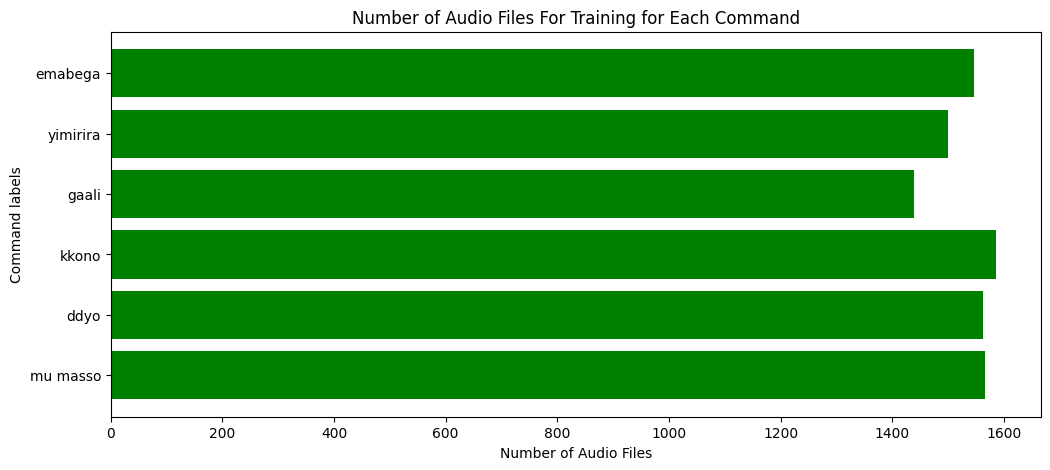

In [9]:
plt.figure(figsize=(12, 5))
plt.barh(list(train_counts.keys()), list(train_counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### 2. Test dataset

In [10]:
print(f'Test \n{test_counts}')
print()

Test 
{'mu masso': 306, 'ddyo': 302, 'kkono': 309, 'gaali': 307, 'yimirira': 306, 'emabega': 301}



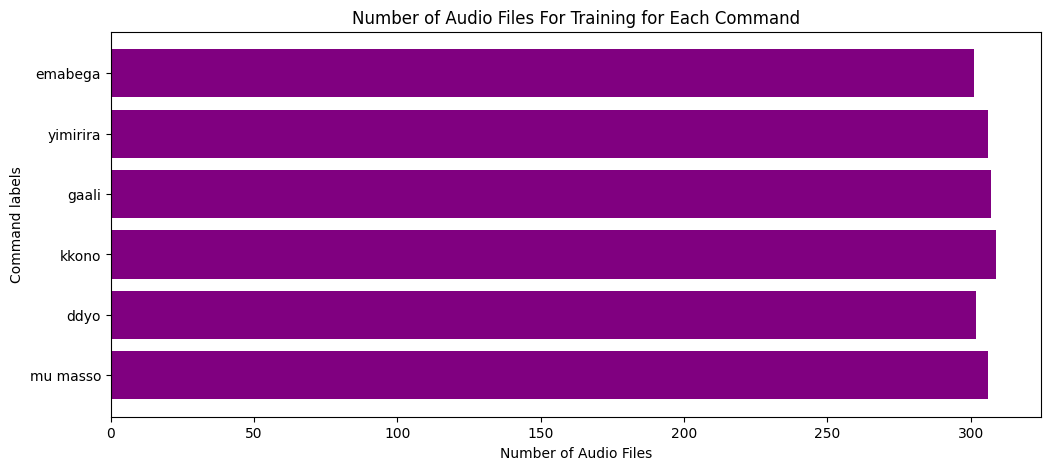

In [11]:
plt.figure(figsize=(12, 5))
plt.barh(list(test_counts.keys()), list(test_counts.values()), color='purple')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### 3. Train & Test dataset

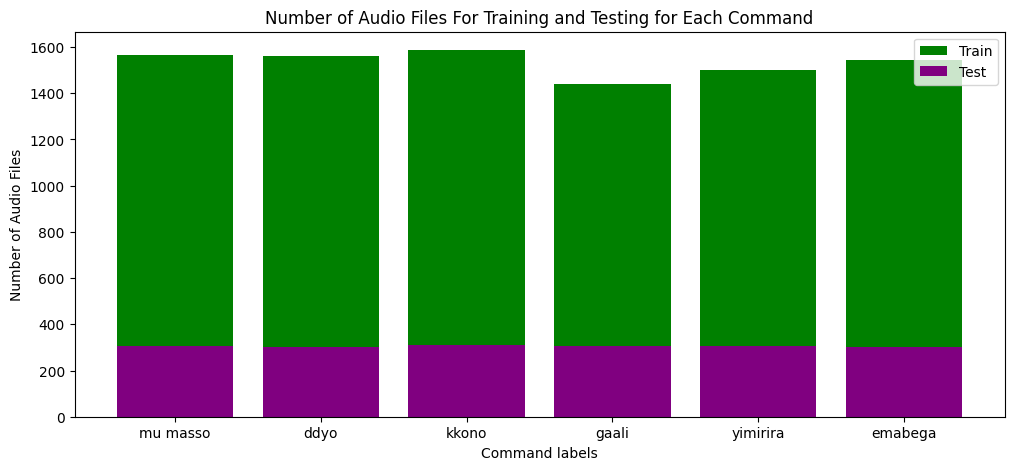

In [12]:
plt.figure(figsize=(12, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='green', label='Train')
plt.bar(test_counts.keys(), test_counts.values(), color='purple', label='Test')
plt.xlabel('Command labels')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files For Training and Testing for Each Command')
plt.legend()
plt.show()

## Audio Properties and Parameters

### Audio Properties

In [13]:
for file_path in file_paths:
    audio_signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    audio = wave.open(file_path, 'rb')

    num_channels = audio.getnchannels()
    frame_rate = audio.getframerate()
    num_frames = audio.getnframes()
    duration = num_frames / float(frame_rate)

    print(f"\nAudio Properties for {os.path.basename(file_path)}")
    print(f"Number of channels:   {num_channels}")
    print(f"Frame rate (Hz):      {frame_rate}")
    print(f"Duration (s):         {duration}")

    audio.close()

print()


Audio Properties for ddyo #107.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.34

Audio Properties for kkono #67.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.6

Audio Properties for emabega #225.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.42

Audio Properties for mu masso #140.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.24

Audio Properties for yimirira-3 #58-05.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.1319375

Audio Properties for gaali #371.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.24



## Play the audio files

In [14]:
for file_path in file_paths:
    print(f"Playing {os.path.basename(file_path)}\n")
    audio = Audio(file_path)
    display(audio)    

Playing ddyo #107.wav



Playing kkono #67.wav



Playing emabega #225.wav



Playing mu masso #140.wav



Playing yimirira-3 #58-05.wav



Playing gaali #371.wav



## Visualize the audio waveform

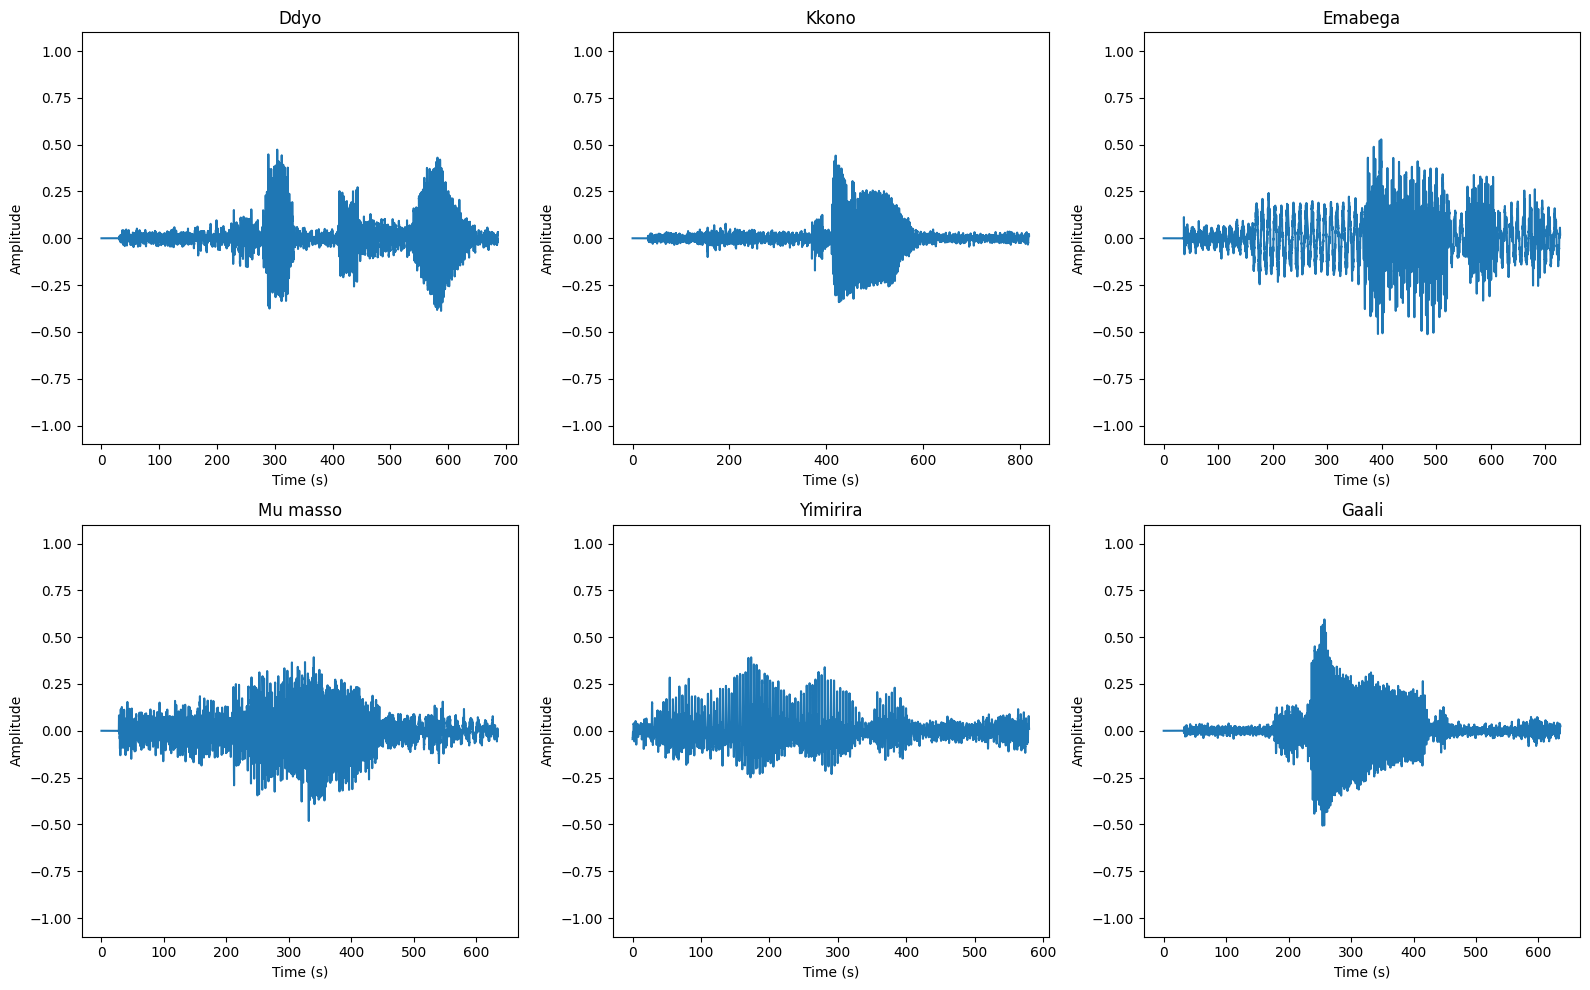

In [15]:
label_names_slice = ['Ddyo', 'Kkono', 'Emabega', 'Mu masso', 'Yimirira', 'Gaali']

plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_path = file_paths[i] 
    audio_signal, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


## Mel_Spectrogram

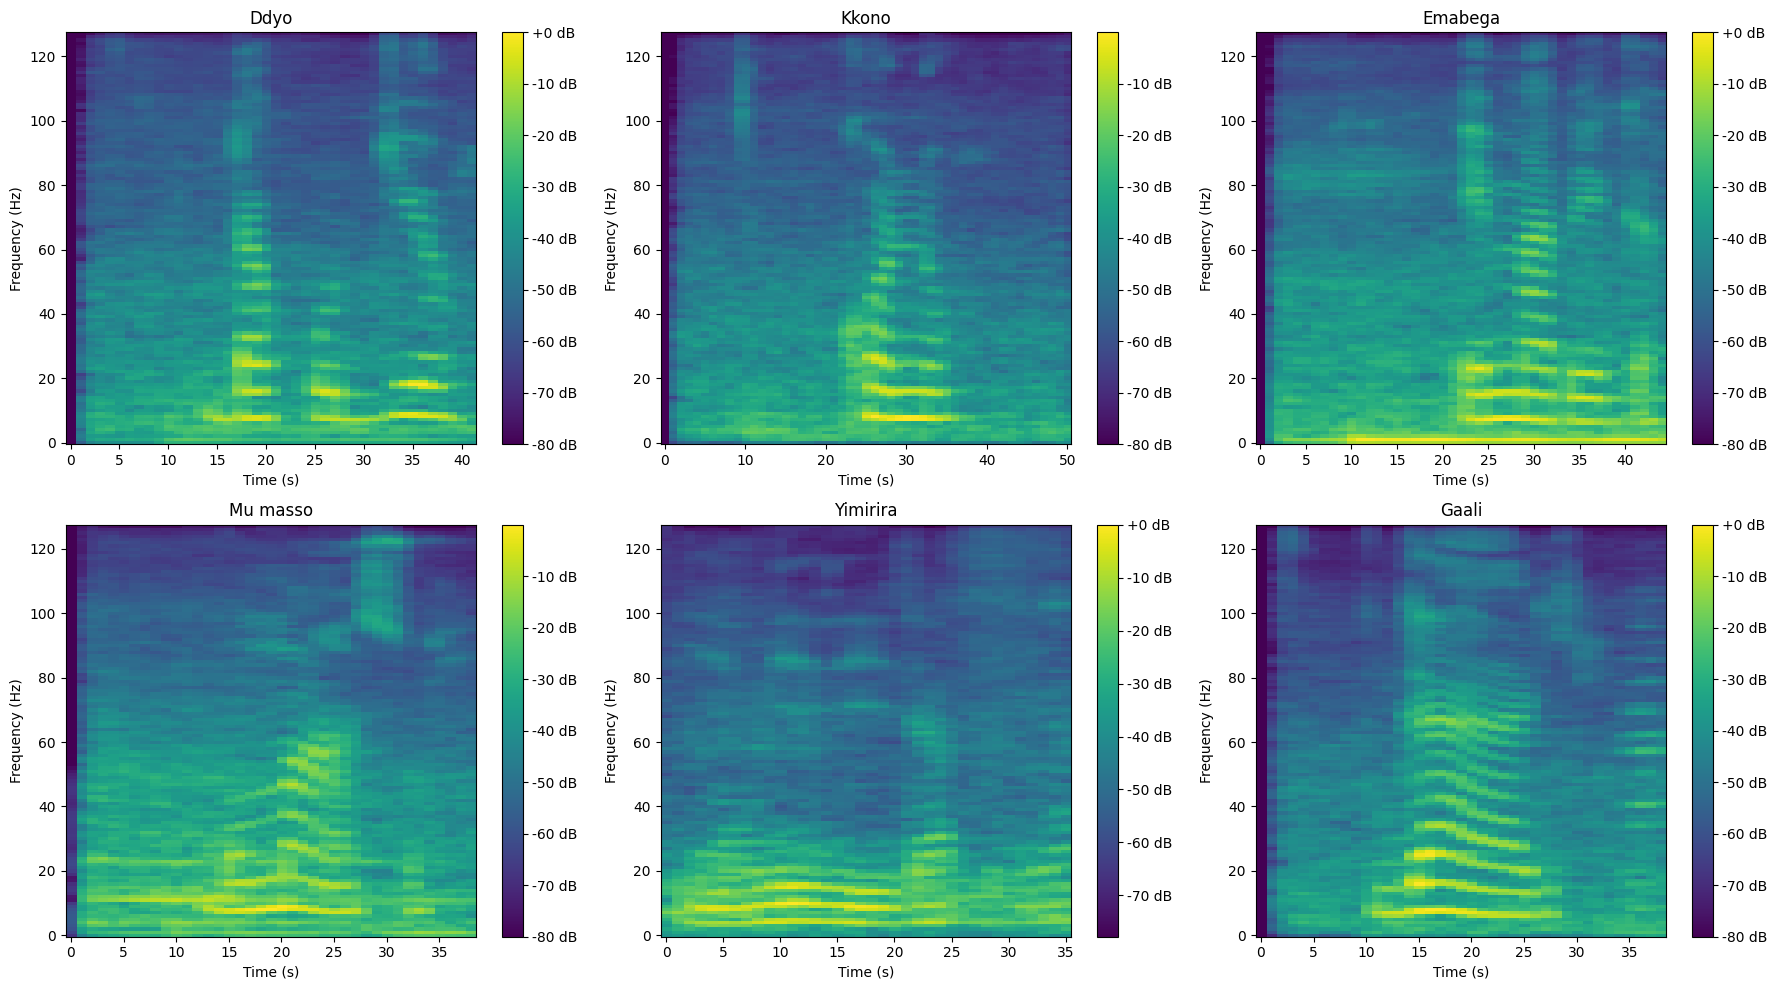

In [16]:
plt.figure(figsize=(18, 10))

# Plot spectrograms
for i, audio_file in enumerate(file_paths, start=1):
    plt.subplot(2, 3, i)
    audio_signal, sample_rate = librosa.load(audio_file, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
    plt.imshow(librosa.power_to_db(spectrogram, ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    plt.title(label_names_slice[i-1])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


# Dataset Preparaption

## 1. Train and validation Datasets

In [17]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()

Found 9203 files belonging to 6 classes.
Using 7363 files for training.
Using 1840 files for validation.



In [18]:
element_spec = train_ds.element_spec
print(element_spec)
print()

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))



In [19]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [20]:
# Inspecting the shape of the audio and label

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## 2. Test dataset

In [21]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)


Found 1831 files belonging to 6 classes.


In [22]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)
print()

(64, 16000)
(64,)



# Feature Extraction

## Mel spectograms

In [23]:
def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=128):
    # Compute the Short-Time Fourier Transform (STFT)
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Convert the magnitude of the STFT to a Mel spectrogram
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=sample_rate
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)  # Log-scale

    # Add an axis for the batch size
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]

    return mel_spectrogram


## Create a figure to hold the subplots

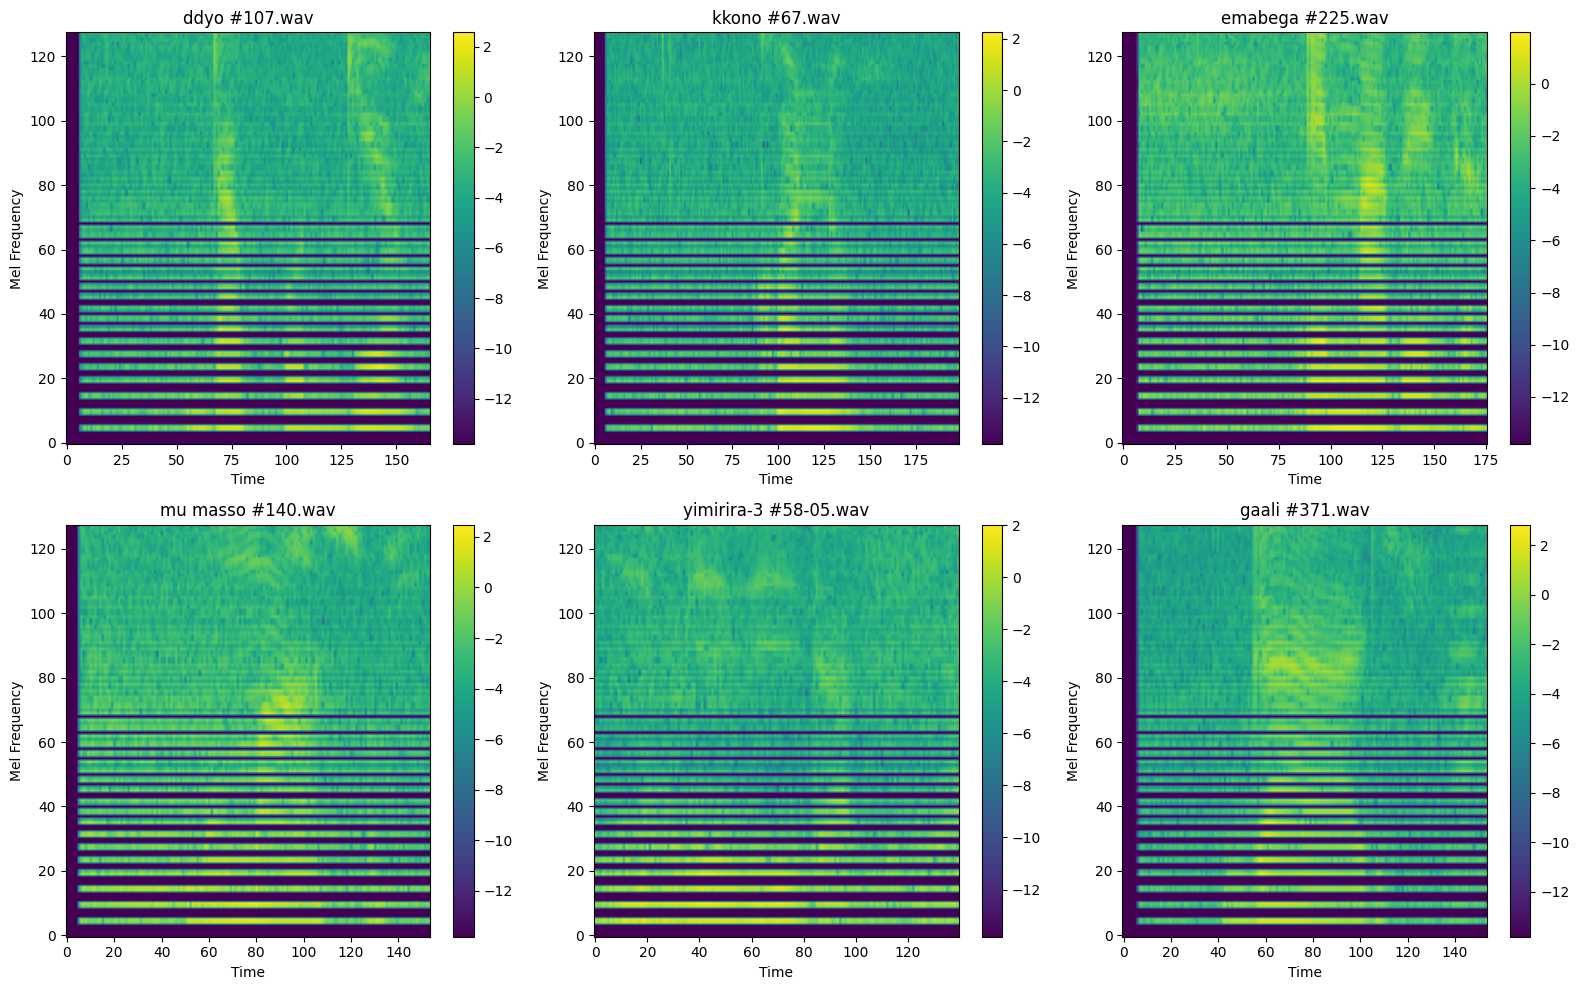

In [24]:
def load_and_compute_mel_spectrogram(file_path, sr=16000):
    """Load an audio file and compute its Mel spectrogram."""
    audio, _ = librosa.load(file_path, sr=sr)
    mel_spectrogram = get_mel_spectrogram(audio)
    return mel_spectrogram

plt.figure(figsize=(16, 10))

# Plot Mel spectrograms
for i, file_path in enumerate(file_paths, 1):
    mel_spectrogram = load_and_compute_mel_spectrogram(file_path)

    # Plot the Mel spectrogram
    plt.subplot(2, 3, i)
    plt.imshow(tf.squeeze(mel_spectrogram).numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(file_path.split('/')[-1])
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar()

plt.tight_layout()
plt.show()


## Mel Spectrogram datasets

In [25]:
def make_mel_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_mel_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_mel_spec_ds = make_mel_spec_ds(train_ds)
val_mel_spec_ds = make_mel_spec_ds(val_ds)
test_mel_spec_ds = make_mel_spec_ds(test_ds)

train_mel_spec_ds = train_mel_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mel_spec_ds = val_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mel_spec_ds = test_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)


# Model Building

## Model 1

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [26]:
example_spectrograms = next(iter(train_mel_spec_ds))[0]

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names_slice)

Input shape: (124, 128, 1)


### Model Arch

In [27]:
learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 124, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0

### Compile the model

In [28]:
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [29]:
EPOCHS = 50
history = model.fit(
    train_mel_spec_ds,
    validation_data=val_mel_spec_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
116/116 [==============================] - 97s 829ms/step - loss: 1.7065 - accuracy: 0.2530 - val_loss: 1.6402 - val_accuracy: 0.3049
Epoch 2/50
116/116 [==============================] - 94s 807ms/step - loss: 1.6029 - accuracy: 0.3289 - val_loss: 1.5635 - val_accuracy: 0.3522
Epoch 3/50
116/116 [==============================] - 133s 1s/step - loss: 1.4943 - accuracy: 0.3940 - val_loss: 1.3959 - val_accuracy: 0.4951
Epoch 4/50
116/116 [==============================] - 104s 901ms/step - loss: 1.2728 - accuracy: 0.5185 - val_loss: 1.1136 - val_accuracy: 0.6179
Epoch 5/50
116/116 [==============================] - 101s 875ms/step - loss: 1.0672 - accuracy: 0.6041 - val_loss: 0.9754 - val_accuracy: 0.6701
Epoch 6/50
116/116 [==============================] - 97s 841ms/step - loss: 0.9338 - accuracy: 0.6583 - val_loss: 0.8751 - val_accuracy: 0.7087
Epoch 7/50
116/116 [==============================] - 108s 936ms/step - loss: 0.8341 - accuracy: 0.7001 - val_loss: 0.8184 - val_a

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

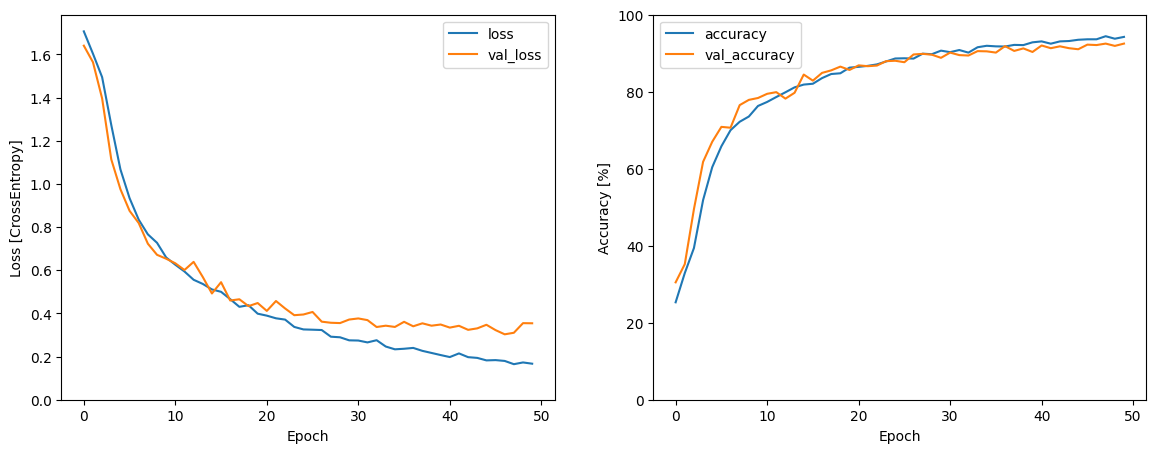

In [30]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [31]:
model.evaluate(test_mel_spec_ds, return_dict=True)

29/29 [==============================] - 8s 276ms/step - loss: 0.2452 - accuracy: 0.9153


{'loss': 0.24515531957149506, 'accuracy': 0.9153468012809753}

In [32]:
y_pred = model.predict(test_mel_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mel_spec_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 8s 267ms/step


In [33]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9201629034670987
Recall: 0.9153468050245768
F1-score: 0.9158059821860542


### Display the confusion matix

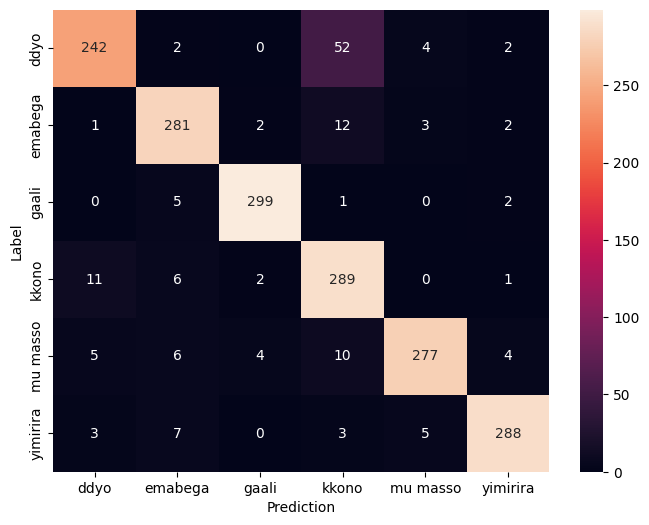

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

1/1 [==============================] - 0s 176ms/step


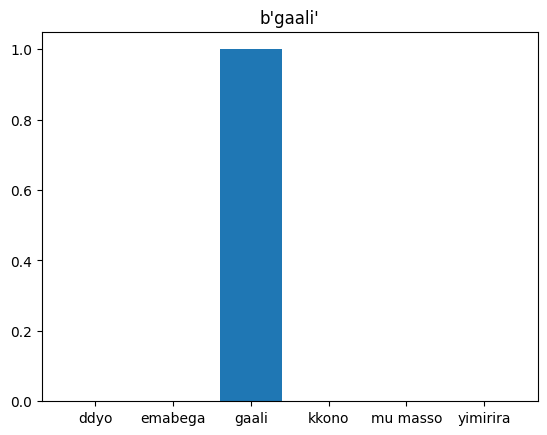

In [35]:
from IPython.display import Audio
import tensorflow as tf

def get_label_names():
    # Assuming `label_names` is a list of label names
    return label_names

file_path_inference = os.path.join(TEST_DATASET_PATH, 'gaali', 'gaali-p #4-27.wav')

x = file_path_inference
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_mel_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model.predict(x)

# Get the labels using tf.py_function
label_names_slice = tf.py_function(func=get_label_names, inp=[], Tout=[tf.string])[0]

predicted_label_index = tf.argmax(prediction[0])
predicted_label = tf.gather(label_names_slice, predicted_label_index)

plt.bar(label_names_slice.numpy(), tf.nn.softmax(prediction[0]))
plt.title(predicted_label.numpy())
plt.show()

Audio(waveform, rate=16000)


1/1 [==============================] - 0s 32ms/step


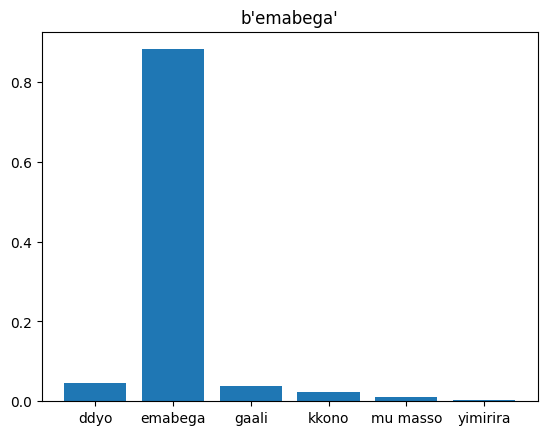

In [36]:
def get_label_names():
    # Assuming `label_names` is a list of label names
    return label_names

file_path_inference = os.path.join(TEST_DATASET_PATH, 'emabega', 'emabega-p #13-28.wav')

x = file_path_inference
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_mel_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model.predict(x)

# Get the labels using tf.py_function
label_names_slice = tf.py_function(func=get_label_names, inp=[], Tout=[tf.string])[0]

predicted_label_index = tf.argmax(prediction[0])
predicted_label = tf.gather(label_names_slice, predicted_label_index)

plt.bar(label_names_slice.numpy(), tf.nn.softmax(prediction[0]))
plt.title(predicted_label.numpy())
plt.show()

Audio(waveform, rate=16000)


## Tensorflow model

In [37]:
KERAS_MODEL_NAME = "Spectrogram_model_1.keras"
model.save(KERAS_MODEL_NAME)

In [38]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


## TFLite Model for model

In [39]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('Spectrogram_model_1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg427bl8n/assets


INFO:tensorflow:Assets written to: /tmp/tmpg427bl8n/assets
2024-03-13 17:20:40.259591: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-13 17:20:40.259617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-13 17:20:40.259909: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg427bl8n
2024-03-13 17:20:40.261692: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-13 17:20:40.261706: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg427bl8n
2024-03-13 17:20:40.265458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-13 17:20:40.266859: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-13 17:20:40.323338: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [40]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='Spectrogram_model_1.tflite')
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [41]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 128   1]


In [42]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [43]:
# Prepare the test dataset 
test_mel_spec_ds = test_mel_spec_ds.unbatch().batch(1)

In [44]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [45]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 91%


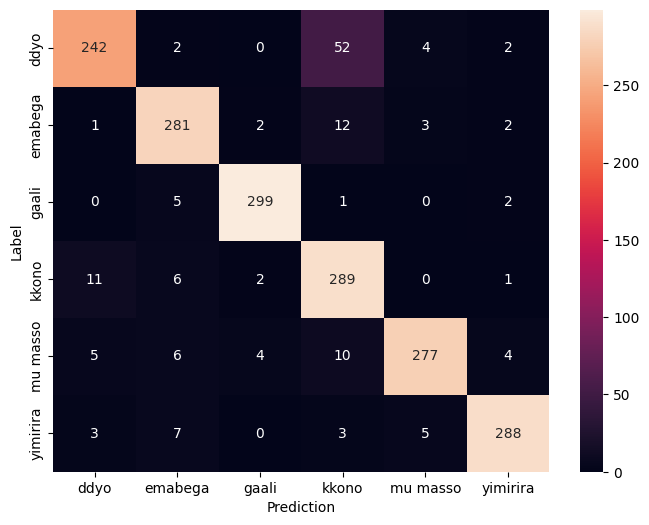

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [47]:
convert_bytes(get_file_size("Spectrogram_model_1.tflite"), "KB")

File size: 436.039 Kilobytes


## Quntized model

In [48]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('Spectrogram_maodel_1.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('Spectrogram_quantized_model_1.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpakwyvxmt/assets


INFO:tensorflow:Assets written to: /tmp/tmpakwyvxmt/assets
2024-03-13 17:20:52.131830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-13 17:20:52.131857: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-13 17:20:52.132022: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpakwyvxmt
2024-03-13 17:20:52.133650: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-13 17:20:52.133663: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpakwyvxmt
2024-03-13 17:20:52.138360: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-13 17:20:52.190924: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpakwyvxmt
2024-03-13 17:20:52.207951: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprw8tn69e/assets


INFO:tensorflow:Assets written to: /tmp/tmprw8tn69e/assets
2024-03-13 17:20:53.581992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-13 17:20:53.582021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-13 17:20:53.582206: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprw8tn69e
2024-03-13 17:20:53.584522: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-13 17:20:53.584536: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprw8tn69e
2024-03-13 17:20:53.589357: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-13 17:20:53.639305: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmprw8tn69e
2024-03-13 17:20:53.655417: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [49]:
convert_bytes(get_file_size("Spectrogram_quantized_model_1.tflite"), "KB")

File size: 120.414 Kilobytes


In [50]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.9153468050245768


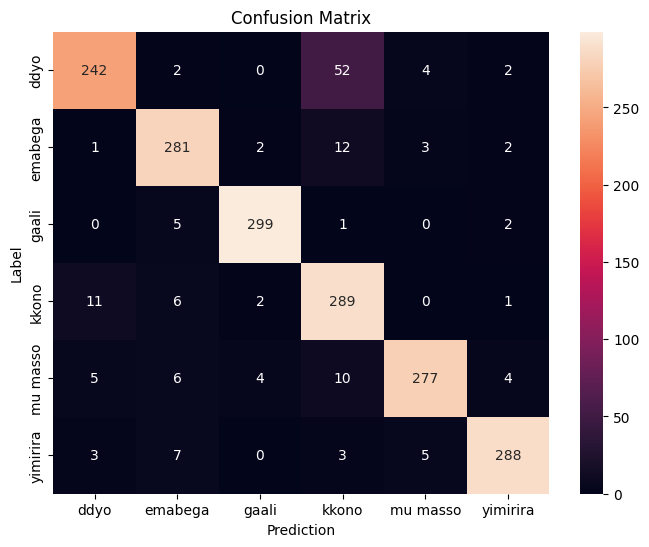

In [51]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [52]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 91%


# Real world testing of the model

In [170]:
# Settings for recording
duration = 2  # Record for 2 seconds
sample_rate = 16000  # Sample rate
channels = 1  # Mono recording

# Record audio from microphone
print("Recording...")
audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')
sd.wait()  # Wait for the recording to finish
print("Recording stopped.")

# Generate a unique filename using current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = f"recording/recorded_audio_{timestamp}.wav"

# Save the recorded audio to a file
sf.write(file_path, audio_data, sample_rate)
print(f"Audio saved as {file_path}")

Recording...
Recording stopped.
Audio saved as recording/recorded_audio_20240313_234350.wav


1/1 [==============================] - 0s 81ms/step


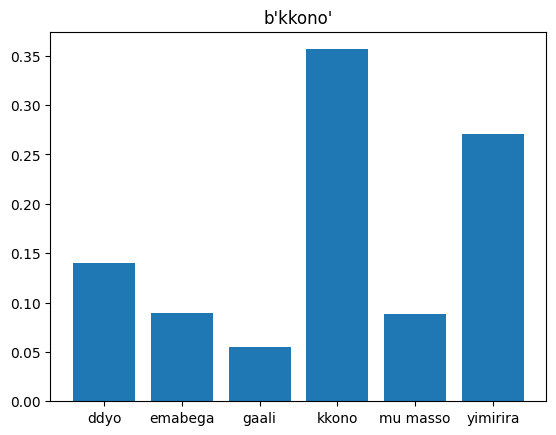

In [171]:
def get_label_names():
    return label_names

# Get the latest audio file saved in the 'recording' directory
latest_audio_file = max([os.path.join('recording', f) for f in os.listdir('recording') if f.endswith('.wav')], key=os.path.getctime)

x = latest_audio_file
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_mel_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model.predict(x)

# Get the labels using tf.py_function
label_names_slice = tf.py_function(func=get_label_names, inp=[], Tout=[tf.string])[0]

predicted_label_index = tf.argmax(prediction[0])
predicted_label = tf.gather(label_names_slice, predicted_label_index)

plt.bar(label_names_slice.numpy(), tf.nn.softmax(prediction[0]))
plt.title(predicted_label.numpy())
plt.show()

Audio(waveform, rate=16000)


In [53]:
import sounddevice as sd
import numpy as np
import tensorflow as tf
import librosa
import soundfile as sf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='Spectrogram_maodel_1.tflite')
interpreter.allocate_tensors()

# Define the function to preprocess audio
def preprocess_audio(audio, sample_rate=16000):
    audio = np.squeeze(audio)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spectrogram = np.log1p(mel_spectrogram)
    mel_spectrogram = mel_spectrogram[np.newaxis, ..., np.newaxis]
    return mel_spectrogram.astype(np.float32)

# Define the callback function for recording audio
def callback(indata, frames, time, status):
    if status:
        print(status)
    audio = np.array(indata)
    audio = preprocess_audio(audio)
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], audio)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    predicted_label_index = np.argmax(output)
    predicted_label = label_names_slice[predicted_label_index]
    print(f"Predicted command: {predicted_label}")

# Start recording audio
duration = 5  # Record for 5 seconds
sample_rate = 16000
channels = 1
recorded_audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')

print('Recording...')
sd.wait()
print('Recording stopped.')

# Save the recorded audio to a file
file_path = 'recorded_audio.wav'
sf.write(file_path, recorded_audio, sample_rate)

# Load the recorded audio file and pass it through the model for prediction
audio, _ = librosa.load(file_path, sr=sample_rate)
audio = preprocess_audio(audio)
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], audio)
interpreter.invoke()
output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
predicted_label_index = np.argmax(output)
predicted_label = label_names_slice[predicted_label_index]
print(f"Predicted command from recorded audio: {predicted_label}")


Recording...
Recording stopped.


ValueError: Cannot set tensor: Dimension mismatch. Got 128 but expected 124 for dimension 1 of input 0.